# Homework 3 - Adversarial Attacks and Contrastive Learning

### Submission in pairs unless otherwise authorized
<ul>
<li> This notebook contains all the questions. You should follow the instructions below.</li>
<li> Solutions for the practical parts should be written in this notebook/py (see submission files) and for the theoretical parts in a pdf report. </li>
</ul>

<h3> Moodle submission</h3>


<p>
You should submit the following files:
</p>
<ul">
<li> Code files:
<ul>
  You can choose 1 of the following options:
  <li>IPYNB notebook:
    <ul>
    <li>All the wet, including the code</li>
    </ul>
  </li>
  <li>PY files:
    <ul>
    <li>4 <code>.py</code> files, one for each question. Submission format for <code>.py</code> files -  HW3_Qn_ID1_ID2.py where n is the question number.</li>
    </ul>
  </li>
</ul>
<li>PDF file - report:
  <ul>
  <li>Answers for all the dry parts - analysis, visualization, dry questions, embeddings.</li>
  </ul>
</li>
</ul>
<p>
All files should be in the following format: "HW3_ID1_ID2.file"
<br>
Good Luck!
</p>

Libraries that can be used in this assignment:

- PyTorch (torch, torchvision, torch.optim, torch.nn, ...) -- Any other deep learning libraries such as keras are prohibited
- NumPy
- Any libraries used for visualization
- PIL (for image processing)

For any libraries other than those listed above, you may ask in the forum.

## Part 1 - Training a CNN on SVHN

Train a classifier on the dataset SVHN (Street View House Numbers), available through ```torchvision.datasets```. The model accuracy should reach at least 90% on the test set. You're free to add as many data augmentations as necessary. Take into consideration that any serious augmentations (like normalization) should be reversed when displaying images in future sections.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

hardware = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_vals = (0.5, 0.5, 0.5)
std_vals = (0.5, 0.5, 0.5)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_vals, std=std_vals)
])

train_data = torchvision.datasets.SVHN(root='./data', split='train', transform=train_transform, download=True)
test_data = torchvision.datasets.SVHN(root='./data', split='test', transform=test_transform, download=True)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=2)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.4)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

network = ConvNet().to(hardware)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=0.001)
lr_adjust = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
grad_scaler = torch.amp.GradScaler()

def train_network(num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        network.train()
        train_prog = tqdm(train_loader, desc="Training", unit="batch")

        for images, labels in train_prog:
            images, labels = images.to(hardware), labels.to(hardware)

            with torch.amp.autocast(device_type='cuda'):
                outputs = network(images)
                loss = loss_function(outputs, labels)

            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            train_prog.set_postfix(loss=loss.item())

        lr_adjust.step()

    # Evaluate the model only once after training
    network.eval()
    correct_preds, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(hardware), labels.to(hardware)
            predictions = network(images)
            _, predicted_labels = torch.max(predictions, 1)
            total_samples += labels.size(0)
            correct_preds += (predicted_labels == labels).sum().item()

    final_accuracy = 100 * correct_preds / total_samples
    print(f"Final Test Accuracy: {final_accuracy:.2f}%")

train_network()


Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Epoch 1/10:


Training: 100%|██████████| 573/573 [00:25<00:00, 22.54batch/s, loss=0.515]


Epoch 2/10:


Training: 100%|██████████| 573/573 [00:24<00:00, 23.56batch/s, loss=0.487]


Epoch 3/10:


Training: 100%|██████████| 573/573 [00:24<00:00, 23.39batch/s, loss=0.281]


Epoch 4/10:


Training: 100%|██████████| 573/573 [00:25<00:00, 22.35batch/s, loss=0.542]


Epoch 5/10:


Training: 100%|██████████| 573/573 [00:26<00:00, 21.88batch/s, loss=0.639]


Epoch 6/10:


Training: 100%|██████████| 573/573 [00:28<00:00, 20.06batch/s, loss=0.109]


Epoch 7/10:


Training: 100%|██████████| 573/573 [00:25<00:00, 22.84batch/s, loss=0.152]


Epoch 8/10:


Training: 100%|██████████| 573/573 [00:28<00:00, 19.89batch/s, loss=0.51]


Epoch 9/10:


Training: 100%|██████████| 573/573 [00:35<00:00, 16.37batch/s, loss=0.148]


Epoch 10/10:


Training: 100%|██████████| 573/573 [00:24<00:00, 23.66batch/s, loss=0.13]


Final Test Accuracy: 93.74%


### Analysis

Analyze the performance of the model on the test set (e.g. through a confusion matrix). Display images that the model predicts incorrectly and their predicted classes. Discuss possible weaknesses of the model and their causes.

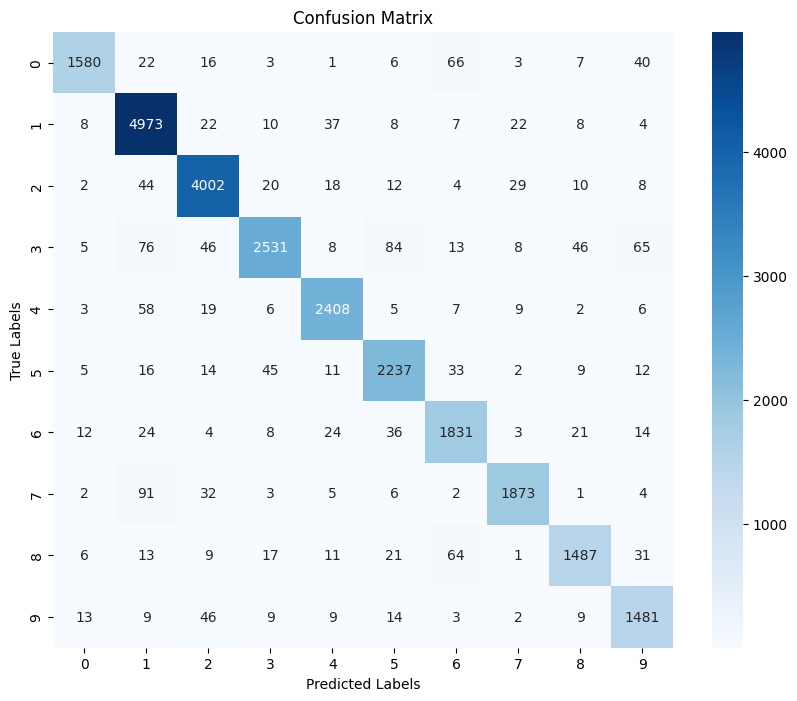


Incorrectly Classified Images by our model :


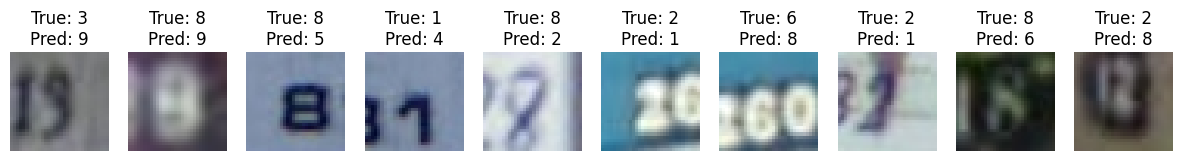

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def reverse_normalization(tensor, mean=mean_vals, std=std_vals):
    mean_tensor = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std_tensor = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    restored_tensor = tensor * std_tensor + mean_tensor
    return torch.clamp(restored_tensor, 0, 1)

def evaluate_network():
    network.eval()

    predictions_list = []
    true_labels_list = []
    misclassified_images = []
    misclassified_preds = []
    misclassified_labels = []

    with torch.no_grad():
        for img_batch, lbl_batch in test_loader:
            img_batch, lbl_batch = img_batch.to(hardware), lbl_batch.to(hardware)
            output_batch = network(img_batch)
            _, predicted_batch = torch.max(output_batch, 1)

            predictions_list.extend(predicted_batch.cpu().numpy())
            true_labels_list.extend(lbl_batch.cpu().numpy())

            for img, pred_lbl, true_lbl in zip(img_batch.cpu(), predicted_batch.cpu(), lbl_batch.cpu()):
                if pred_lbl != true_lbl:
                    misclassified_images.append(img)
                    misclassified_preds.append(pred_lbl.item())
                    misclassified_labels.append(true_lbl.item())

    confusion_mat = confusion_matrix(true_labels_list, predictions_list)
    label_names = [str(i) for i in range(10)]

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    class_wise_acc = confusion_mat.diagonal() / confusion_mat.sum(axis=1)

    display_count = min(10, len(misclassified_images))
    print("\nIncorrectly Classified Images by our model :")
    fig, axes = plt.subplots(1, display_count, figsize=(15, 5))

    for i, ax in enumerate(axes):
        img = reverse_normalization(misclassified_images[i].unsqueeze(0)).squeeze().permute(1, 2, 0).cpu().numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {misclassified_labels[i]}\nPred: {misclassified_preds[i]}")

    plt.show()

evaluate_network()

## Part 2: Adversarial Attacks on our Model

Implement the FGSM algorithm as shown in the tutorial (it may be necessary to make require_grad be True for our input data in order to calculate its gradient). Define a function ```eval_adversarial(model, test_loader, epsilon)``` that applies FGSM on the test data by creating new images which are perturbed versions of the originals, and calculates the model's accuracy only on the perturbed images. Test accuracy after the attack should be less than 25% for $\varepsilon=0.1$.

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    """
    Generate adversarial examples using the FGSM attack.
    """
    loss_function = nn.CrossEntropyLoss()

    model.zero_grad()

    logits = model(images)
    loss_value = loss_function(logits, labels)

    loss_value.backward()

    gradient_sign = images.grad.data.sign()

    adversarial_examples = images + epsilon * gradient_sign

    return adversarial_examples

def eval_adversarial(model, test_loader, epsilon):
    """
    Evaluate model accuracy on adversarial examples generated via FGSM.
    """
    correct_predictions = 0
    total_samples = 0
    model.eval()

    for batch_images, batch_labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
        batch_images, batch_labels = batch_images.to(hardware), batch_labels.to(hardware)

        batch_images.requires_grad = True

        adversarial_samples = fgsm_attack(model, batch_images, batch_labels, epsilon)

        perturbed_outputs = model(adversarial_samples.detach())

        _, predicted_classes = perturbed_outputs.max(1)

        total_samples += batch_labels.size(0)
        correct_predictions += (predicted_classes == batch_labels).sum().item()

    adversarial_accuracy = correct_predictions / total_samples * 100

    return adversarial_accuracy

epsilon = 0.1
adversarial_accuracy = eval_adversarial(network, test_loader, epsilon)
print(f"Adversarial Accuracy: {adversarial_accuracy:.2f}%")

Evaluating: 100%|██████████| 204/204 [00:16<00:00, 12.45batch/s]

Adversarial Accuracy: 10.21%


### Visualization

Visualize some images that the model got right before the perturbation and wrong after the attack. Create a confusion matrix of the output on the entire test set.

Test the function with different values of epsilon (at least 5) and plot the accuracy as a function of epsilon. For each epsilon, display the perturbed images with the model's classification. At what epsilon does it become harder for the human eye to correctly classify?

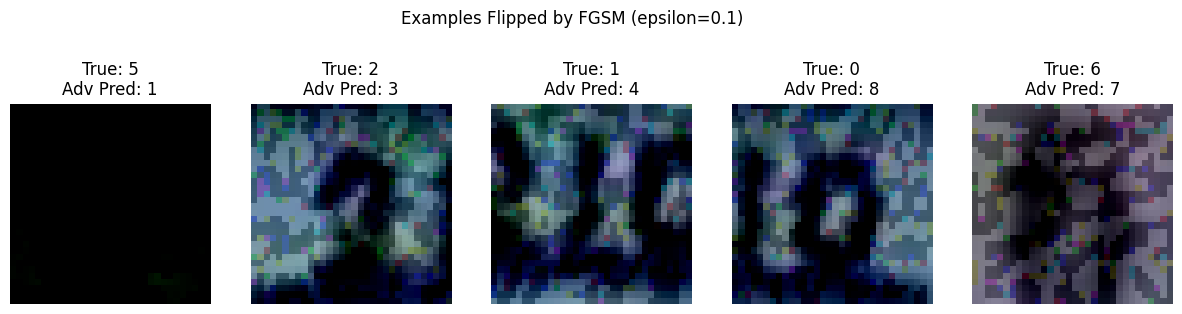

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Ensure the network is in eval mode
network.eval()

def visualize_flipped_predictions(model, loader, epsilon, max_samples=5):
    """
    Visualize samples that were originally correct but become misclassified after FGSM attack.
    """
    model.eval()

    # Lists to store images that got flipped
    flipped_images = []
    flipped_true_labels = []
    flipped_adv_preds = []

    # We'll collect only up to 'max_samples' flipped examples for visualization
    collected = 0

    # Define a loss function for FGSM
    loss_fn = nn.CrossEntropyLoss()

    for images, labels in loader:
        images, labels = images.to(hardware), labels.to(hardware)

        # 1) Get baseline predictions on the clean images
        with torch.no_grad():
            clean_outputs = model(images)
            _, clean_preds = torch.max(clean_outputs, 1)

        # 2) Generate adversarial images using FGSM
        images.requires_grad = True
        adv_outputs = model(images)
        loss = loss_fn(adv_outputs, labels)
        model.zero_grad()
        loss.backward()

        # The FGSM perturbation
        fgsm_perturbation = epsilon * images.grad.data.sign()
        adv_images = images + fgsm_perturbation
        adv_images = torch.clamp(adv_images, 0, 1)  # keep images in valid range [0,1]

        # 3) Get predictions on the adversarial images
        with torch.no_grad():
            adv_preds_outputs = model(adv_images)
            _, adv_preds = torch.max(adv_preds_outputs, 1)

        # 4) Identify which were correct originally but wrong now
        for i in range(len(labels)):
            if clean_preds[i] == labels[i] and adv_preds[i] != labels[i]:
                flipped_images.append(adv_images[i].detach().cpu())
                flipped_true_labels.append(labels[i].detach().cpu().item())
                flipped_adv_preds.append(adv_preds[i].detach().cpu().item())

                collected += 1
                if collected >= max_samples:
                    break
        if collected >= max_samples:
            break

    # 5) Visualize a few flipped examples
    if len(flipped_images) == 0:
        print("No samples were flipped from correct to incorrect at this epsilon.")
        return

    fig, axes = plt.subplots(1, len(flipped_images), figsize=(15, 4))
    if len(flipped_images) == 1:
        axes = [axes]  # Make it iterable

    for idx, ax in enumerate(axes):
        img = flipped_images[idx]
        # Reverse normalization if you're storing normalized images
        # but here, we used clamp(0,1) above for adv_images.
        # If your pipeline includes normalization, you might want to
        # "reverse_normalization" the images for correct visual colors.
        # For demonstration, let's assume the images are in [0,1].

        # Optionally reverse normalization if needed:
        # img = reverse_normalization(img.unsqueeze(0)).squeeze()

        np_img = img.permute(1, 2, 0).numpy()
        ax.imshow(np.clip(np_img, 0, 1))
        ax.axis('off')
        ax.set_title(f"True: {flipped_true_labels[idx]}\nAdv Pred: {flipped_adv_preds[idx]}")

    plt.suptitle(f"Examples Flipped by FGSM (epsilon={epsilon})")
    plt.show()

# Example usage:
epsilon = 0.1
visualize_flipped_predictions(network, test_loader, epsilon, max_samples=5)


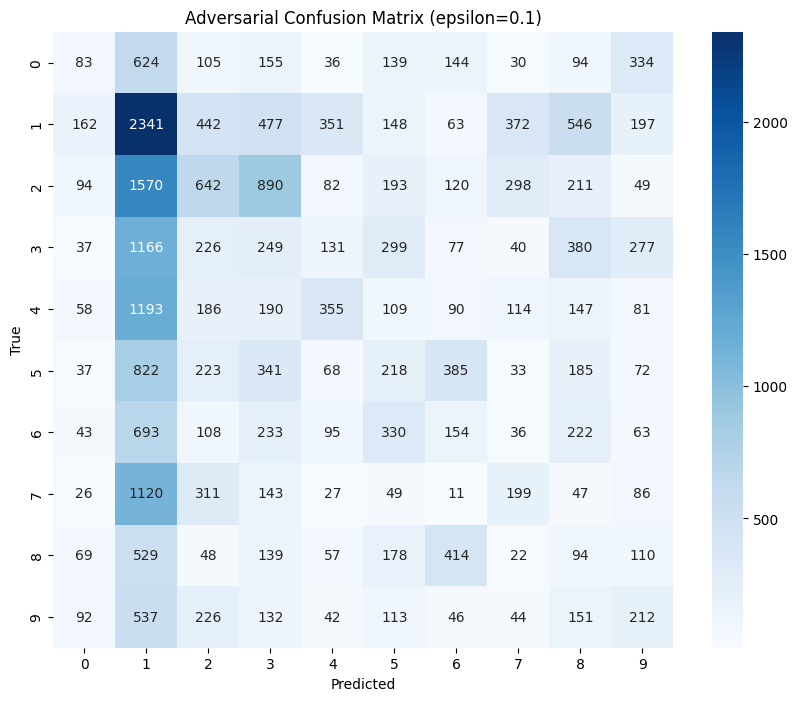

In [ ]:
def confusion_matrix_adversarial(model, loader, epsilon):
    """
    Generate a confusion matrix for predictions on adversarial images.
    """
    model.eval()

    all_true = []
    all_adv_preds = []

    # Define loss function for FGSM
    loss_fn = nn.CrossEntropyLoss()

    for images, labels in loader:
        images, labels = images.to(hardware), labels.to(hardware)

        # **Ensure requires_grad is set**
        images.requires_grad = True  # ✅ Enable gradients for FGSM

        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # Backprop to get gradients
        model.zero_grad()
        loss.backward()

        # FGSM attack
        perturbation = epsilon * images.grad.sign()
        adv_images = images + perturbation
        adv_images = torch.clamp(adv_images, 0, 1)  # Keep within valid range

        # Predictions on adversarial data
        with torch.no_grad():  # ✅ Only disable grad here (not before FGSM)
            adv_outputs = model(adv_images)
            _, adv_preds = torch.max(adv_outputs, 1)

        # Collect labels and predictions
        all_true.extend(labels.cpu().tolist())
        all_adv_preds.extend(adv_preds.cpu().tolist())

    # Compute confusion matrix
    cm = confusion_matrix(all_true, all_adv_preds)
    return cm

# Create and plot the confusion matrix
cm_adv = confusion_matrix_adversarial(network, test_loader, epsilon)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_adv, annot=True, fmt='d', cmap='Blues',
            xticklabels=[str(i) for i in range(10)],
            yticklabels=[str(i) for i in range(10)])
plt.title(f"Adversarial Confusion Matrix (epsilon={epsilon})")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Evaluating: 100%|██████████| 204/204 [00:17<00:00, 11.85batch/s]


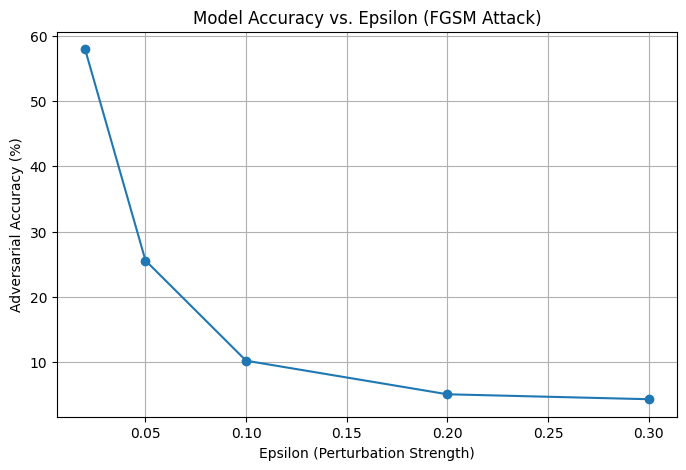

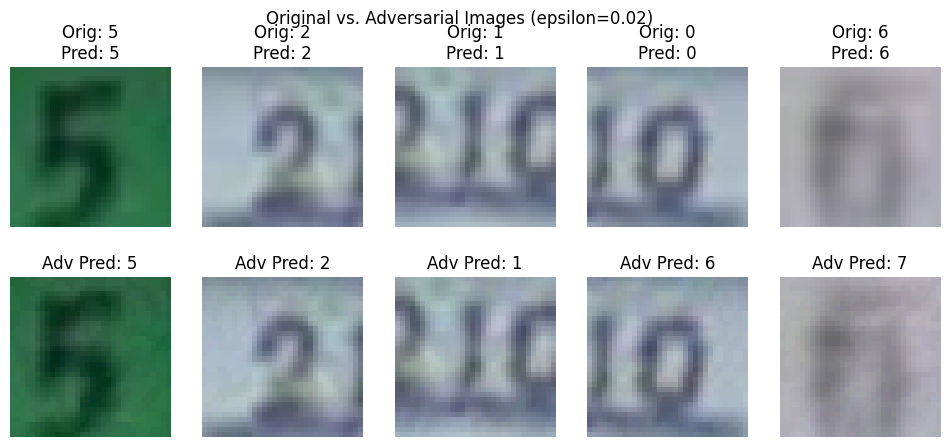

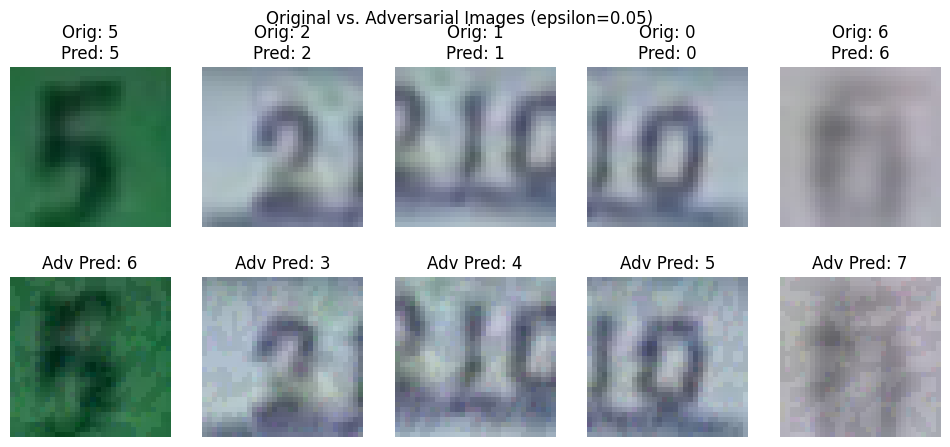

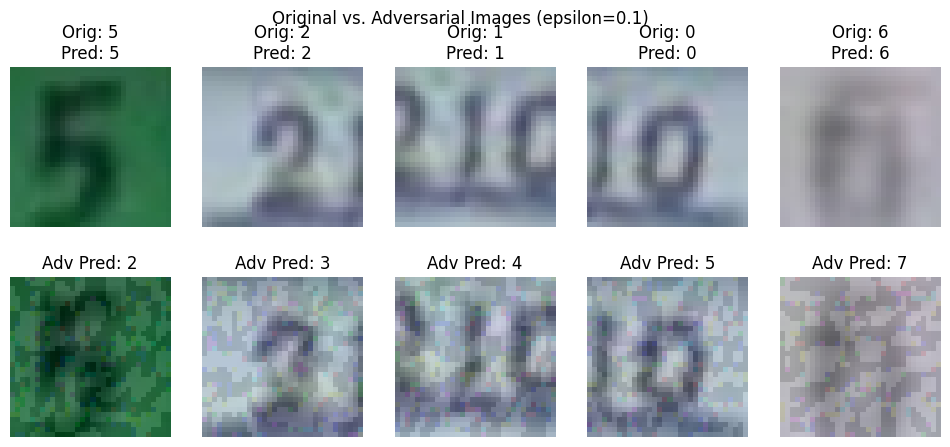

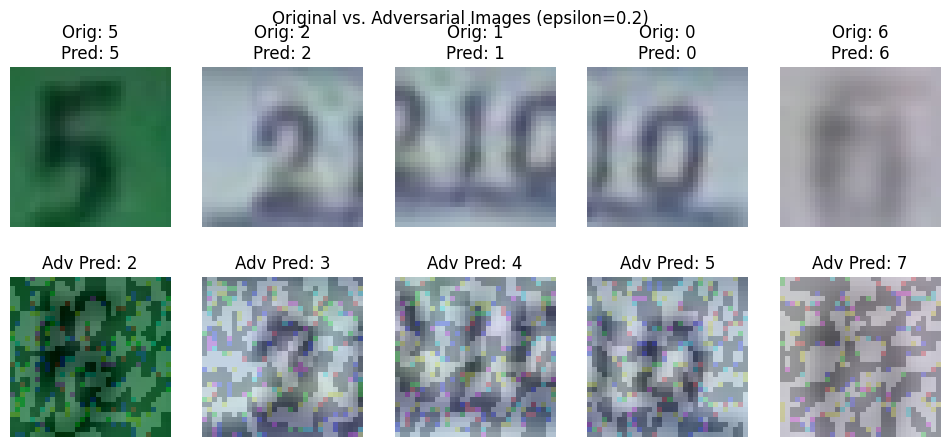

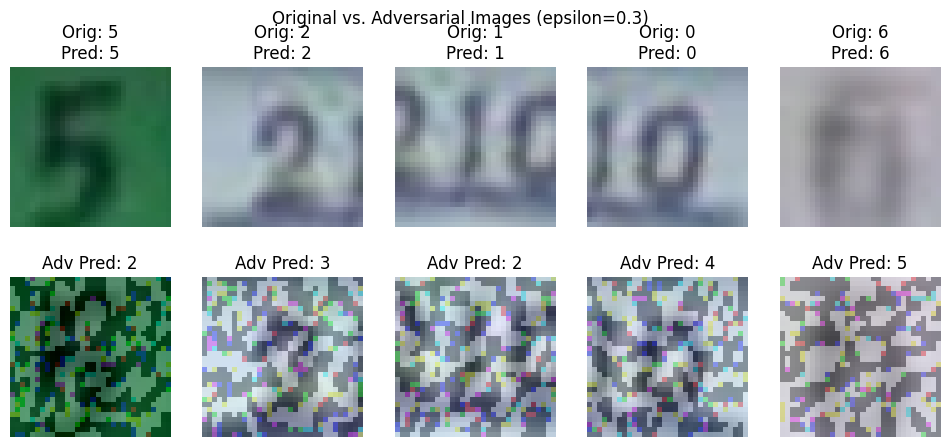

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define a range of epsilon values to test
epsilon_values = [0.02, 0.05, 0.1, 0.2, 0.3]

# Store accuracies for each epsilon
accuracies = []

for eps in epsilon_values:
    acc = eval_adversarial(network, test_loader, eps)
    accuracies.append(acc)

# Plot accuracy as a function of epsilon
plt.figure(figsize=(8, 5))
plt.plot(epsilon_values, accuracies, marker='o', linestyle='-')
plt.xlabel("Epsilon (Perturbation Strength)")
plt.ylabel("Adversarial Accuracy (%)")
plt.title("Model Accuracy vs. Epsilon (FGSM Attack)")
plt.grid(True)
plt.show()

def visualize_adversarial_examples(model, loader, epsilon, num_images=5):
    """
    Display original and adversarial images along with model predictions.
    """
    model.eval()
    fig, axes = plt.subplots(2, num_images, figsize=(12, 5))

    for images, labels in loader:
        images, labels = images[:num_images].to(hardware), labels[:num_images].to(hardware)

        images.requires_grad = True
        adv_images = fgsm_attack(model, images, labels, epsilon)

        with torch.no_grad():
            original_preds = model(images).argmax(dim=1).cpu().numpy()
            adversarial_preds = model(adv_images).argmax(dim=1).cpu().numpy()

        for i in range(num_images):
            # Original image
            img_orig = reverse_normalization(images[i].unsqueeze(0)).squeeze().permute(1, 2, 0).cpu().detach().numpy()
            axes[0, i].imshow(np.clip(img_orig, 0, 1))
            axes[0, i].axis("off")
            axes[0, i].set_title(f"Orig: {labels[i].item()}\nPred: {original_preds[i]}")

            # Adversarial image
            img_adv = reverse_normalization(adv_images[i].unsqueeze(0)).squeeze().permute(1, 2, 0).cpu().detach().numpy()
            axes[1, i].imshow(np.clip(img_adv, 0, 1))
            axes[1, i].axis("off")
            axes[1, i].set_title(f"Adv Pred: {adversarial_preds[i]}")

        break  # Only visualize once

    plt.suptitle(f"Original vs. Adversarial Images (epsilon={epsilon})")
    plt.show()


# Visualize adversarial images for different epsilon values
for eps in epsilon_values:
    visualize_adversarial_examples(network, test_loader, eps)


## Part 3: Training our model using adversarial training

For each point in the training data, increase the model's robustness by training not only on the point itself, but on the perturbed point after the FGSM algorithm using $\varepsilon=0.1$. Afterwards, compute the accuracy once again on the newly trained model using ```eval_adversarial(model, test_loader, epsilon)``` defined above. The accuracy (LOOKING ONLY AT THE PERTURBED DATA) should be at least 70%.

In [ ]:
def train_network_adversarial(num_epochs=10, epsilon=0.1):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}:")
        network.train()
        train_prog = tqdm(train_loader, desc="Training", unit="batch")

        for images, labels in train_prog:
            images, labels = images.to(hardware), labels.to(hardware)
            images.requires_grad = True

            # Generate adversarial examples
            adv_images = fgsm_attack(network, images, labels, epsilon)

            # Combine original and adversarial samples
            combined_images = torch.cat([images, adv_images], dim=0)
            combined_labels = torch.cat([labels, labels], dim=0)

            with torch.amp.autocast(device_type='cuda'):
                outputs = network(combined_images)
                loss = loss_function(outputs, combined_labels)

            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()

            train_prog.set_postfix(loss=loss.item())

        lr_adjust.step()

    # Evaluate on clean test set after adversarial training
    network.eval()
    correct_preds, total_samples = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(hardware), labels.to(hardware)
            predictions = network(images)
            _, predicted_labels = torch.max(predictions, 1)
            total_samples += labels.size(0)
            correct_preds += (predicted_labels == labels).sum().item()
    final_accuracy = 100.0 * correct_preds / total_samples
    print(f"Final Test Accuracy after Adversarial Training: {final_accuracy:.2f}%")

train_network_adversarial(num_epochs=10, epsilon=0.1)




Epoch 1/10:


Training: 100%|██████████| 573/573 [01:12<00:00,  7.87batch/s, loss=0.696]


Epoch 2/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.71batch/s, loss=0.587]


Epoch 3/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.72batch/s, loss=0.764]


Epoch 4/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.66batch/s, loss=0.407]


Epoch 5/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.64batch/s, loss=0.466]


Epoch 6/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.71batch/s, loss=0.394]


Epoch 7/10:


Training: 100%|██████████| 573/573 [01:16<00:00,  7.49batch/s, loss=0.327]


Epoch 8/10:


Training: 100%|██████████| 573/573 [01:14<00:00,  7.70batch/s, loss=0.475]


Epoch 9/10:


Training: 100%|██████████| 573/573 [01:15<00:00,  7.57batch/s, loss=0.605]


Epoch 10/10:


Training: 100%|██████████| 573/573 [01:15<00:00,  7.59batch/s, loss=0.235]


Final Test Accuracy after Adversarial Training: 94.51%


In [ ]:
adversarial_accuracy = eval_adversarial(network, test_loader, epsilon)
print('')
print(f"Adversarial Accuracy after Adversarial Training: {adversarial_accuracy:.2f}%")


Evaluating: 100%|██████████| 204/204 [00:15<00:00, 12.81batch/s]


Adversarial Accuracy after Adversarial Training: 80.90%


### Visualization

Display the confusion matrix along with some examples of images that the model classified incorrectly. Discuss the performance of the model now compared to before.

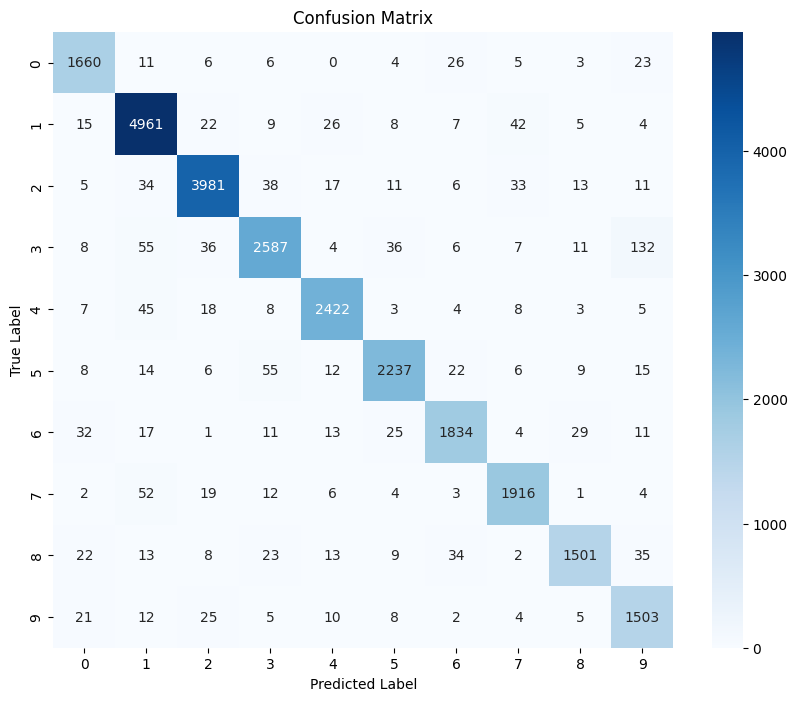

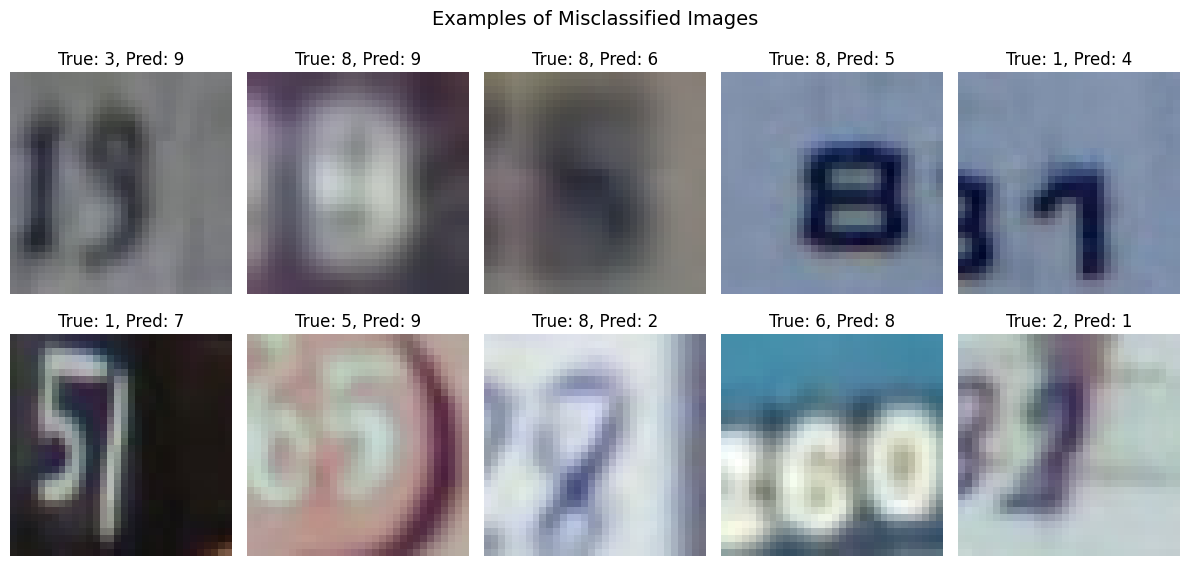

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Ensure the model is in evaluation mode
network.eval()

# Lists to store predictions and true labels
all_preds = []
all_labels = []
misclassified_images = []
misclassified_preds = []
misclassified_labels = []

# Collect predictions
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(hardware), labels.to(hardware)
        outputs = network(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Store misclassified images
        misclassified_idxs = (predicted != labels).cpu().numpy()
        if len(misclassified_images) < 10:  # Collect up to 10 misclassified images
            misclassified_images.extend(images[misclassified_idxs].cpu())
            misclassified_preds.extend(predicted[misclassified_idxs].cpu().numpy())
            misclassified_labels.extend(labels[misclassified_idxs].cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Display misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Examples of Misclassified Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < len(misclassified_images):
        image = misclassified_images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy
        image = (image * 0.5) + 0.5  # Unnormalize

        ax.imshow(image)
        ax.set_title(f"True: {misclassified_labels[i]}, Pred: {misclassified_preds[i]}")
        ax.axis("off")

plt.tight_layout()
plt.show()


## Part 4: Contrastive Learning

In this section, we will work on creating informative embeddings for images using SimCLR. For this section we will use the attached subset of the popular ImageNet dataset of 96x96 images from 1000 classes. Below, we provide you with several functions to implement a contrastive learning model.

### Dry Questions

Before implementation, take these questions in consideration (and provide your answers and explanations):

1. When training an unsupervised contrastive learning model such as SimCLR, would we prefer to have a large or small batch size?
2. In general, what possible evaluation metrics could be used in this task (unsupervised representation learning) to measure our model's performance?
3. When creating embeddings for images in the test set, how does the process differ from what we do in training?
4. For each of the following image augmentations, explain whether or not we would like to use them in the SimCLR framework:
    - Randomly cropping a fixed-size window in the image.
    - Enlarging the image to 128x128.
    - Random rotation of the image.
    - Adding Gaussian noise.
    - Randomly changing the image's dimensions.
    - Randomly converting the image to grayscale.

### Code

Do the following:

1. Create a CNN that makes embeddings for images (you can use pretrained foundation models if you'd like).
2. Implement any unsupervised contrastive loss (such as nt-xent in SimCLR).
3. Train the model (achieve loss less than 3.0).

In [2]:
from PIL import Image
import os
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox  # For visualization
from sklearn.manifold import TSNE  # Dimensionality Reduction

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

import math
import os
from PIL import Image

In [3]:
import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")

# Define paths for train and test sets
TRAIN_PATH = f"{path}/tiny-imagenet-200/train"
TEST_PATH = f"{path}/tiny-imagenet-200/test"
BATCH_SIZE = 256

100%|██████████| 474M/474M [00:23<00:00, 21.4MB/s]

Extracting files...


In [4]:
class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        """
        Initialize the dataset with the root directory and the transform to be applied.
        """
        self.root = root
        self.transform = transform
        self.imgs = []
        for label in os.listdir(root):
            if os.path.isdir(os.path.join(root, label, 'images')):
                for img in os.listdir(os.path.join(root, label, 'images')):
                    self.imgs.append(os.path.join(root, label, 'images', img))

    def __len__(self):
        """
        Return the length of the dataset.
        """
        return len(self.imgs)

    def __getitem__(self, idx):
        """
        Fetch the image and apply two different augmentations to it.
        """
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')  # Ensure it's in RGB format

        if self.transform:
            img1 = self.transform(img)  # First random augmentation
            img2 = self.transform(img)  # Second random augmentation
        else:
            img1, img2 = img, img

        return img1, img2  # Return both augmented versions


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imgs = []
        for label in os.listdir(root):
            for img in os.listdir(os.path.join(root, label)):
                self.imgs.append(os.path.join(root, label, img))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img_transform = self.transform(img)
        return transforms.ToTensor()(img), img_transform  # Return the original image (for visualization) and the image that will be used in the model


data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter()], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transforms = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = TrainDataset(TRAIN_PATH, transform=data_transforms)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_data = TestDataset(TEST_PATH, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class ContrastiveResNet18(nn.Module):
    def __init__(self):
        super(ContrastiveResNet18, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove the FC layer

        # Projection head
        self.projection_head = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 256),  # First layer
            nn.BatchNorm1d(256),  # Normalization for stable learning
            nn.ReLU(),
            nn.Linear(256, 128),  # Intermediate layer
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64)  # Final embedding size
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)  # Flatten feature map
        x = self.projection_head(x)
        return x


def nt_xent_loss(embeddings1, embeddings2, temp=0.5):
    """
    Computes the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss for contrastive learning.

    Parameters:
    - features_a: Tensor of embeddings from the first augmented batch.
    - features_b: Tensor of embeddings from the second augmented batch.
    - temp: Temperature scaling factor for similarity scores.

    Returns:
    - Contrastive loss value.
    """
    batch_size = embeddings1.size(0)

    # Concatenate feature vectors from both views
    combined_features = torch.cat([embeddings1, embeddings2], dim=0)

    # Compute cosine similarity matrix
    similarity_scores = torch.matmul(combined_features, combined_features.T) / temp

    # Construct label vector
    target_labels = torch.cat([torch.arange(batch_size) for _ in range(2)]).to(combined_features.device)

    # Compute cross-entropy loss
    loss_function = nn.CrossEntropyLoss()
    loss_value = loss_function(similarity_scores, target_labels)

    return loss_value



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Instantiate the model and move it to the device
model = ContrastiveResNet18().to(device)

# Define an optimizer (Adam here, but feel free to experiment with others)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Number of epochs
num_epochs = 2

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_loss = 0.0

    for batch_idx, (img1, img2) in enumerate(train_loader):
        # Move images to device
        img1, img2 = img1.to(device), img2.to(device)

        # Forward pass
        emb1 = model(img1)  # Embedding for the first augmented view
        emb2 = model(img2)  # Embedding for the second augmented view

        # Compute the contrastive loss
        loss = nt_xent_loss(emb1, emb2)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], "
                  f"Loss: {loss.item():.4f}")

    avg_epoch_loss = total_loss / len(train_loader)
    print(f"==> Epoch [{epoch+1}/{num_epochs}] Complete: Avg. Loss = {avg_epoch_loss:.4f}")

Using device: cuda
Epoch [1/2], Step [10/390], Loss: 3.3444
Epoch [1/2], Step [20/390], Loss: 2.9374
Epoch [1/2], Step [30/390], Loss: 2.3468
Epoch [1/2], Step [40/390], Loss: 2.5537
Epoch [1/2], Step [50/390], Loss: 2.2174
Epoch [1/2], Step [60/390], Loss: 2.1252
Epoch [1/2], Step [70/390], Loss: 2.2383
Epoch [1/2], Step [80/390], Loss: 2.0770
Epoch [1/2], Step [90/390], Loss: 2.1859
Epoch [1/2], Step [100/390], Loss: 2.1801
Epoch [1/2], Step [110/390], Loss: 2.1366
Epoch [1/2], Step [120/390], Loss: 2.1155
Epoch [1/2], Step [130/390], Loss: 1.9585
Epoch [1/2], Step [140/390], Loss: 2.0746
Epoch [1/2], Step [150/390], Loss: 1.8939
Epoch [1/2], Step [160/390], Loss: 1.8283
Epoch [1/2], Step [170/390], Loss: 1.8016
Epoch [1/2], Step [180/390], Loss: 1.9056
Epoch [1/2], Step [190/390], Loss: 1.7343
Epoch [1/2], Step [200/390], Loss: 1.9121
Epoch [1/2], Step [210/390], Loss: 1.6913
Epoch [1/2], Step [220/390], Loss: 1.7840
Epoch [1/2], Step [230/390], Loss: 1.7262
Epoch [1/2], Step [240/3

In [7]:
# Define a path to save the model
MODEL_SAVE_PATH = "contrastive_resnet18.pth"

# Save the model after training
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to contrastive_resnet18.pth


Using the function ```plot_embeddings```, show the model's performance on the test data.

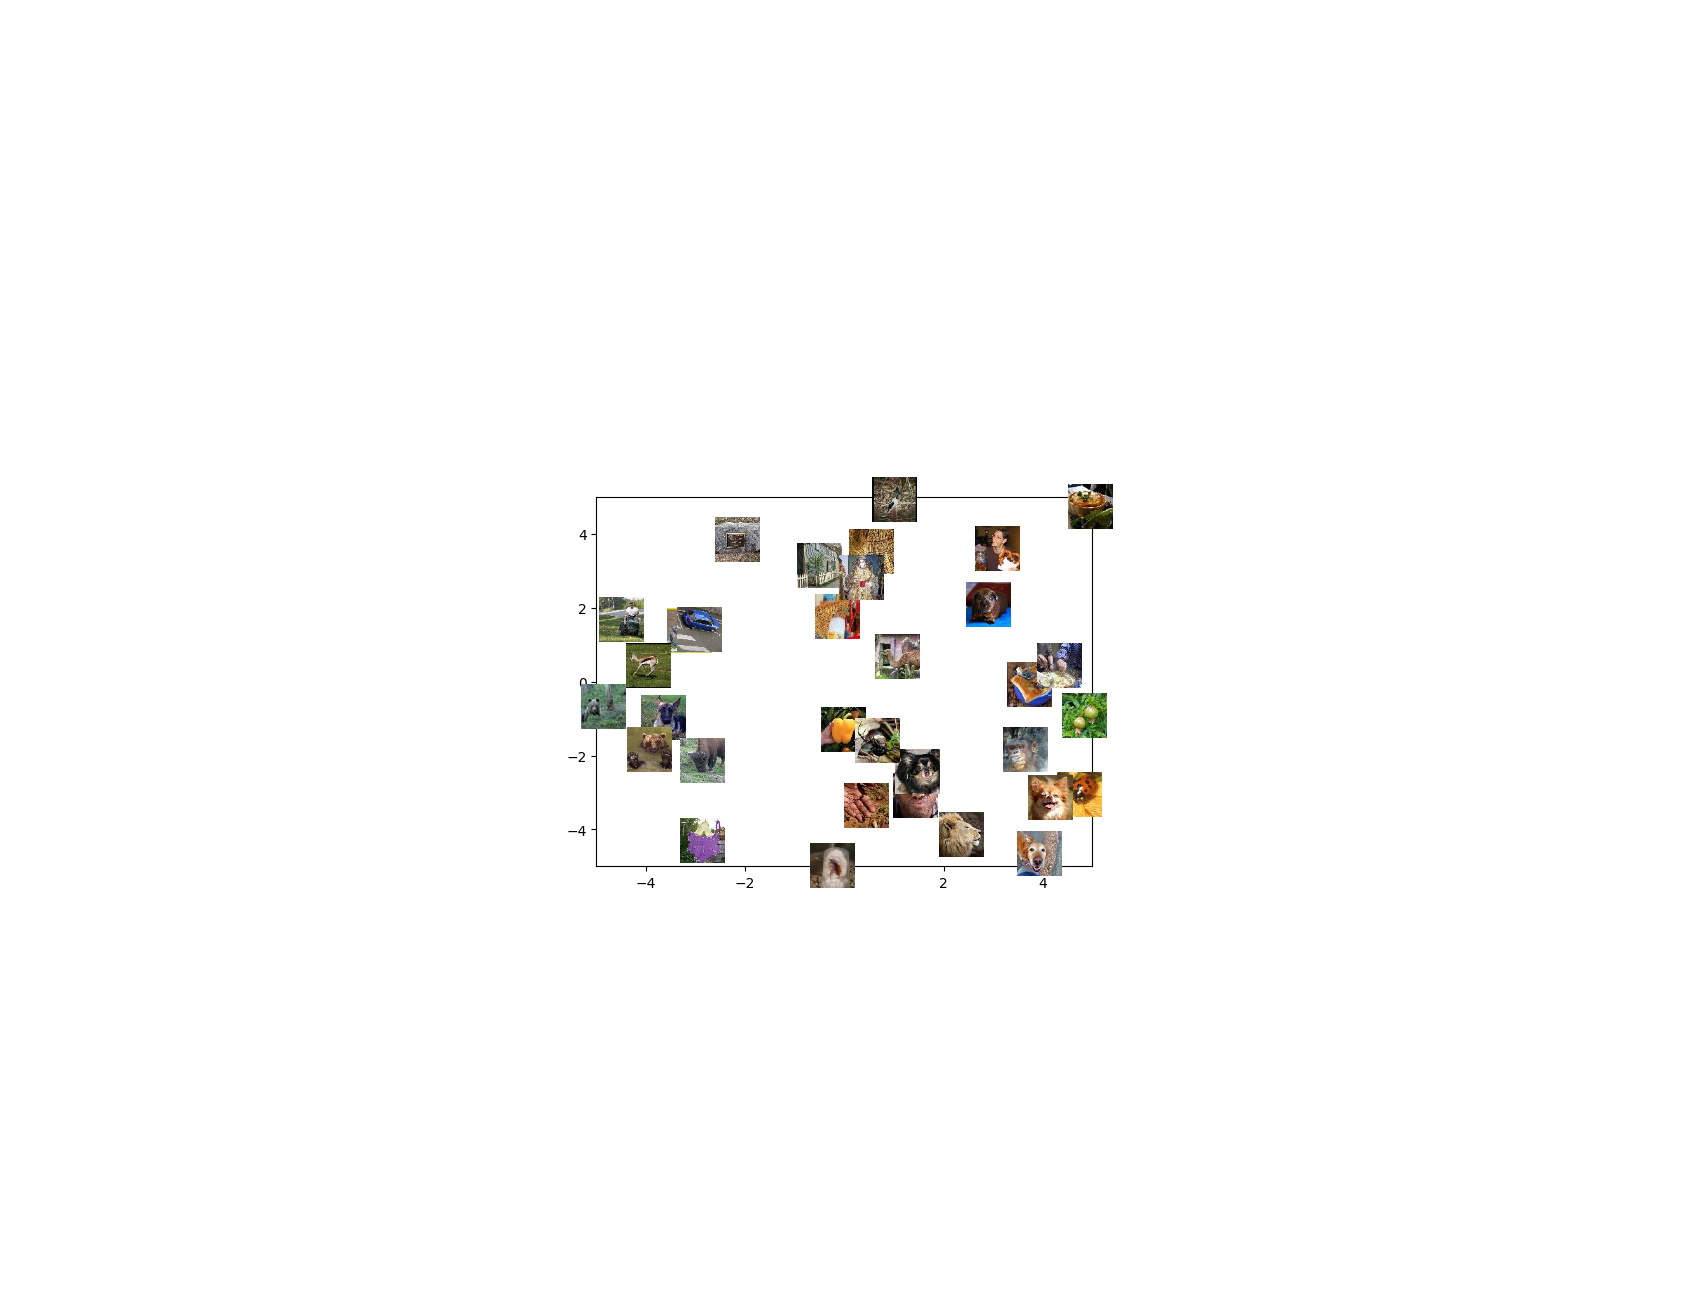

In [11]:
def plot_embeddings(model, test_loader, device):
    """
    This function creates embeddings for each image in the first batch of the test loader, projects them to 2D and displays them on a plot.
    """
    for img, img_transform in test_loader:
        img_transform = img_transform.to(device)
        embeddings = model(img_transform)
        tsne = TSNE(n_components=2)
        embeddings = tsne.fit_transform(embeddings.cpu().detach().numpy())

        fig, ax = plt.subplots()
        ax.set_xlim(-5, 5)
        ax.set_ylim(-5, 5)
        for i in range(embeddings.shape[0]):
            curr_img = img[i].permute(1,2,0)
            curr_img = OffsetImage(curr_img, zoom=0.5)
            ab = AnnotationBbox(curr_img, embeddings[i], frameon=False)
            ax.add_artist(ab)
        plt.show()
        return

plot_embeddings(model, test_loader, device)

For some batch of the test loader, take 3 images in the batch. For each image, find and display the 5 images that have the closest embeddings to them. Do the chosen images make sense? If not, what could have possibly gone wrong with your model?

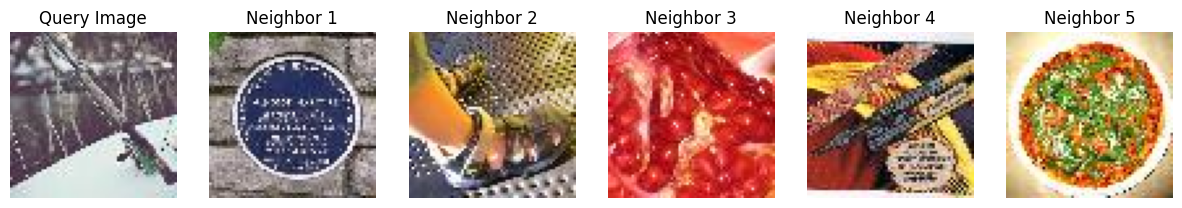

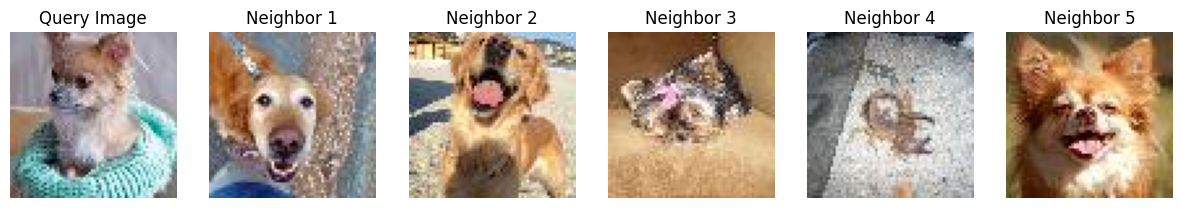

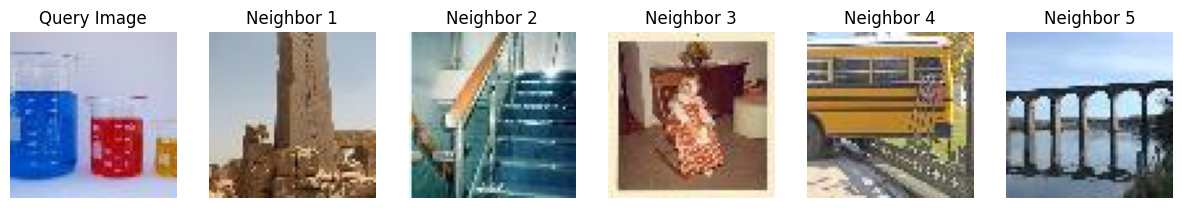

In [12]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def visualize_nearest_neighbors(model, data_loader, query_count=3, neighbor_count=5):
    """
    Displays the closest images to a set of randomly chosen query images based on model embeddings.

    Parameters:
    - model: Trained model for feature extraction.
    - data_loader: Dataloader for the test set.
    - query_count: Number of query images to select.
    - neighbor_count: Number of closest images to retrieve.
    """
    model.eval()
    with torch.no_grad():
        for original_images, processed_images in data_loader:
            processed_images = processed_images.to(device)
            feature_vectors = model(processed_images)
            feature_vectors = F.normalize(feature_vectors, p=2, dim=1)

            # Select random query images
            query_indices = torch.randperm(len(original_images))[:query_count]
            query_images = original_images[query_indices]
            query_features = feature_vectors[query_indices]

            # Compute pairwise distances
            distance_matrix = torch.cdist(query_features, feature_vectors, p=2)

            for i, (query_img, distances) in enumerate(zip(query_images, distance_matrix)):
                closest_indices = distances.topk(neighbor_count + 1, largest=False).indices[1:]

                fig, axes = plt.subplots(1, neighbor_count + 1, figsize=(15, 5))
                axes[0].imshow(query_img.permute(1, 2, 0))
                axes[0].set_title("Query Image")
                axes[0].axis("off")

                for j, idx in enumerate(closest_indices):
                    closest_image = original_images[idx].permute(1, 2, 0)
                    axes[j + 1].imshow(closest_image)
                    axes[j + 1].set_title(f"Neighbor {j+1}")
                    axes[j + 1].axis("off")

                plt.show()

            break  # Process only one batch

visualize_nearest_neighbors(model, test_loader)
